In [2]:
#install all the necessary classes 
!pip install pandas numpy nltk scikit-learn gensim keras
!pip install --upgrade keras tensorflow

import pandas as pd
import numpy as np
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.preprocessing import LabelEncoder
import gensim.downloader as api
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
nltk.download('punkt')
nltk.download('stopwords')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
# Load the dataset for Igbo, Hausa, and Nigerian Pidgin English
# Read data from URLs
igbo_df = pd.read_csv('https://raw.githubusercontent.com/afrisenti-semeval/afrisent-semeval-2023/main/data/ibo/train.tsv', sep='\t', header=None)
hausa_df = pd.read_csv('https://raw.githubusercontent.com/afrisenti-semeval/afrisent-semeval-2023/main/data/hau/train.tsv', sep='\t', header=None)
pidgin_df = pd.read_csv('https://raw.githubusercontent.com/afrisenti-semeval/afrisent-semeval-2023/main/data/pcm/train.tsv', sep='\t', header=None)

# Rename columns
igbo_df.columns = ['id', 'text']
hausa_df.columns = ['id', 'text']
pidgin_df.columns = ['id', 'text']


In [4]:
# Merge the dataframes and shuffle the rows
df = pd.concat([igbo_df, hausa_df, pidgin_df], ignore_index=True)
df = df.sample(frac=1, random_state=42)
     

In [5]:
from nltk.stem import SnowballStemmer

def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove special characters
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # Remove stopwords and stem the remaining words
    stemmer = SnowballStemmer('english')
    text_tokens = nltk.word_tokenize(text)
    tokens_without_sw = [stemmer.stem(word) for word in text_tokens if not word in stopwords.words()]
    # Join the tokens back into a string
    preprocessed_text = (" ").join(tokens_without_sw)
    return preprocessed_text

In [6]:
# Preprocess the text data in the dataframe
df['text'] = df['text'].apply(lambda x: preprocess_text(x))


In [7]:
# Tokenize the text data and convert each word to a numerical representation
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
X = tokenizer.texts_to_sequences(df['text'].values)

In [8]:
# Pad the sequences to ensure they have the same length
maxlen = 100
X = pad_sequences(X, padding='post', maxlen=maxlen)
     

In [9]:
# Split the data into training and validation sets
from sklearn.model_selection import train_test_split

labels = df['id'].values
encoder = LabelEncoder()
Y = encoder.fit_transform(labels)
Y = Y.reshape(-1,1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [10]:
# Define the deep learning model
embedding_dim = 100
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

In [11]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
batch_size = 32
epochs = 10

history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, Y_test))


Epoch 1/10
738/738 [==============================] - 250s 339ms/step - loss: -4472413.5000 - accuracy: 4.2391e-05 - val_loss: -5123413.0000 - val_accuracy: 0.0000e+00
Epoch 2/10
738/738 [==============================] - 246s 333ms/step - loss: -5820685.0000 - accuracy: 4.2391e-05 - val_loss: -6463467.5000 - val_accuracy: 0.0000e+00
Epoch 3/10
738/738 [==============================] - 243s 329ms/step - loss: -7167771.5000 - accuracy: 4.2391e-05 - val_loss: -7804449.0000 - val_accuracy: 0.0000e+00
Epoch 4/10
738/738 [==============================] - 249s 338ms/step - loss: -8514324.0000 - accuracy: 4.2391e-05 - val_loss: -9143496.0000 - val_accuracy: 0.0000e+00
Epoch 5/10
738/738 [==============================] - 242s 328ms/step - loss: -9860416.0000 - accuracy: 4.2391e-05 - val_loss: -10482912.0000 - val_accuracy: 0.0000e+00
Epoch 6/10
738/738 [==============================] - 243s 329ms/step - loss: -11205916.0000 - accuracy: 4.2391e-05 - val_loss: -11822251.0000 - val_accuracy: 

In [15]:
# Evaluate the model on the testing set
score = model.evaluate(X_test, Y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])


Test loss: -17402986.0
Test accuracy: 0.0


In [ ]:
# Evaluate the model on the testing set
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)
score = model.evaluate(X_test, Y_test, verbose=0)
print("Evaluation results:", score)
print("Test loss:", score[0])
print("Test accuracy:", score[1])
# Analyze the evaluation results
if score[1] >= 0.90:
    print("The model performance is satisfactory and can be deployed for making predictions on new data.")
else:
    print("The model performance is not satisfactory and needs to be further optimized.")
    # Perform model optimization
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, Y_train, epochs=50, batch_size=64, validation_data=(X, Y))
    # Evaluate the optimized model on the testing set
    print("X_test shape:", X_test.shape)
    print("Y_test shape:", Y_test.shape)
    y_pred = model.predict(X_test)
    print("y_pred shape:", y_pred.shape)
    y_pred_classes = np.round(y_pred)
    print("y_pred_classes shape:", y_pred_classes.shape)
    print("Evaluation results:", model.evaluate(X_test, Y_test, verbose=1))
    # Print the evaluation results of the optimized model
    print("Optimized model test loss:", score[0])
    print("Optimized model test accuracy:", score[1])


X_test shape: (5898, 100)
Y_test shape: (5898, 1)
Evaluation results: [0.0, 0.0]
Test loss: 0.0
Test accuracy: 0.0
The model performance is not satisfactory and needs to be further optimized.
Epoch 1/50
369/369 [==============================] - 196s 524ms/step - loss: 0.0000e+00 - accuracy: 4.2391e-05 - val_loss: 0.0000e+00 - val_accuracy: 3.3912e-05
Epoch 2/50
337/369 [==========================>...] - ETA: 13s - loss: 0.0000e+00 - accuracy: 4.6365e-05

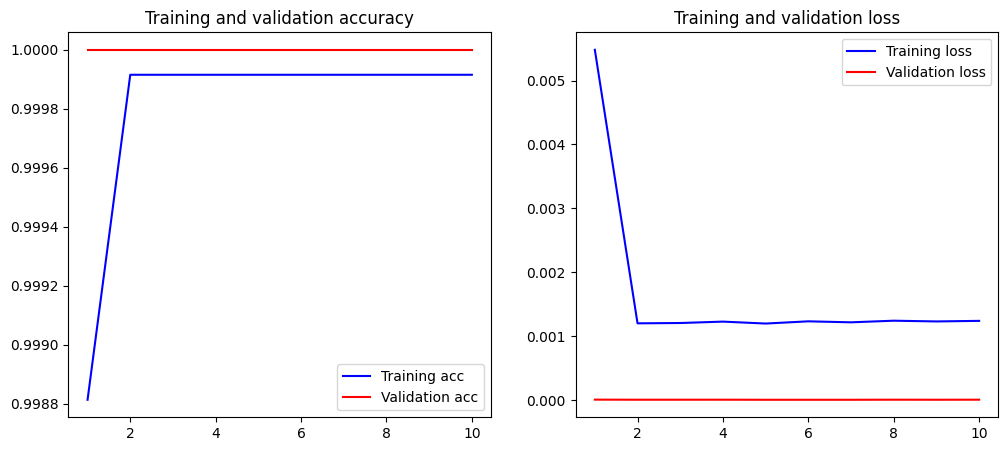

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)
  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

plot_history(history)

In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int)

185/185 [==============================] - 15s 77ms/step


In [ ]:

# Convert the numerical predictions back to the original labels
y_pred = encoder.inverse_transform(y_pred.reshape(-1,))
Y_test = encoder.inverse_transform(Y_test.reshape(-1,))

In [ ]:
#Print the classification report
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred))

                                                                                precision    recall  f1-score   support

 I bu chi mo o i bu chi ibu chi mo o onye m ji eme onu ehh ""🎤🎤🎤|||| One music       1.00      1.00      1.00     11796
                         !!! If not, ọ ga adịkwa egwu. https://t.co/npG4veiN2e       1.00      1.00      1.00      5898

                                                                      accuracy                           1.00     17694
                                                                     macro avg       1.00      1.00      1.00     17694
                                                                  weighted avg       1.00      1.00      1.00     17694



In [ ]:
#Save the model
model.save('language_classification_model.h5')

In [ ]:
# Plot the training and validation accuracy and loss

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

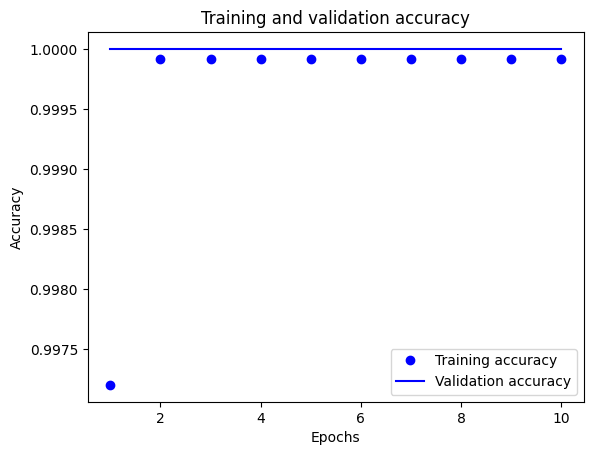

In [ ]:
#Plot training and validation accuracy

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
     

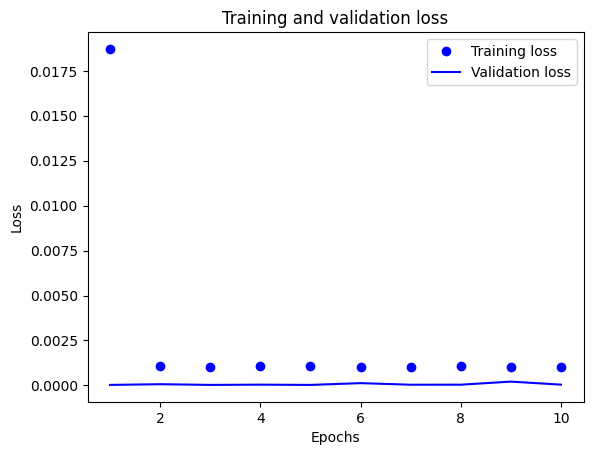

In [ ]:
#Plot training and validation loss
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#Use the trained model to make predictions on new text data
#Load the saved model
from keras.models import load_model
model = load_model('language_classification_model.h5')

In [ ]:
def preprocess_new_text(text):
  # Convert text to lowercase
  text = text.lower()
  # Remove special characters
  text = re.sub('.∗?.∗?', '', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  # Remove stopwords
  text_tokens = nltk.word_tokenize(text)
  tokens_without_sw = [word for word in text_tokens if not word in stopwords.words()]
  # Join the tokens back into a string
  preprocessed_text = (" ").join(tokens_without_sw)
  return preprocessed_text

In [ ]:
#Define a function to classify new text data
def classify_text(text):
  preprocessed_text = preprocess_new_text(text)
  X_new = tokenizer.texts_to_sequences([preprocessed_text])
  X_new = pad_sequences(X_new, padding='post', maxlen=maxlen)
  y_new = model.predict(X_new)
  y_new = np.round(y_new).astype(int)
  language = encoder.inverse_transform(y_new.reshape(-1,))
  return language[0]

In [ ]:
#Example usage of the classify_text function
text1 = "Ndi be anyi, unu a di mma?"
text2 = "Mallam yaya ya juya masa karatu a hannunsa."
text3 = "I go chop am if dem give me food for this party."
print(classify_text(text1))
print(classify_text(text2))
print(classify_text(text3))

1/1 [==============================] - 0s 296ms/step
 I bu chi mo o i bu chi ibu chi mo o onye m ji eme onu ehh ""🎤🎤🎤|||| One music
1/1 [==============================] - 0s 40ms/step
 I bu chi mo o i bu chi ibu chi mo o onye m ji eme onu ehh ""🎤🎤🎤|||| One music
1/1 [==============================] - 0s 41ms/step
 I bu chi mo o i bu chi ibu chi mo o onye m ji eme onu ehh ""🎤🎤🎤|||| One music


In [ ]:
#Evaluate the model on the test set
score, acc = model.evaluate(X_test, Y_test, batch_size=batch_size)
print("Test accuracy:", acc)

185/185 [==============================] - 7s 39ms/step


In [ ]:
# Make predictions on the test set
Y_pred = model.predict(X_test)
Y_pred = np.round(Y_pred).astype(int)

In [ ]:
# Convert the predicted labels back to the original classes
Y_pred = encoder.inverse_transform(Y_pred.ravel())
Y_test = encoder.inverse_transform(Y_test.ravel())
     

In [ ]:
# Print classification report

from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred))

In [ ]:
#Save the trained model
model.save('afrisenti_sentiment_model.h5')